<a href="https://colab.research.google.com/github/siting1206/NLP_FinalProject/blob/main/bert_RTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation & Import Package

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Download the RTE Dataset


In [3]:
!pip install git+https://github.com/Adapter-Hub/adapter-transformers.git
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Adapter-Hub/adapter-transformers.git to /tmp/pip-req-build-07lw0mz9
  Running command git clone -q https://github.com/Adapter-Hub/adapter-transformers.git /tmp/pip-req-build-07lw0mz9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 6.5 MB/s 
     |████████████████████████████████| 182 kB 77.5 MB/s 
  Created wheel for adapter-transformers: filename=adapter_transformers-3.2.0a0-py3-none-any.whl size=5601770 sha256=2bb0a9aaadfdec4261e9d0b822835849dca5f45b6efaf29a8a7593275a1c40ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-hom1nunu/wheels/ae/d3/bf/2cda8a83068958276e50c60058e87223acd5a9df015f04a65a
Successfully built adapter-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 

In [4]:
import wget
import os

print('Downloading dataset...')

# 資料集的下載連結
url = 'https://dl.fbaipublicfiles.com/glue/data/RTE.zip'

# 如本地沒有，則下載資料集 
if not os.path.exists('/content/drive/MyDrive/NLP_final_project/rte_public_1.1.zip'):
    wget.download(url, '/content/drive/MyDrive/NLP_final_project/rte_public_1.1.zip')

In [5]:
# 如果沒解壓過，則解壓zip包
if not os.path.exists('/content/drive/MyDrive/NLP_final_project/rte_public/'):
    !unzip /content/drive/MyDrive/NLP_final_project/rte_public_1.1.zip

In [6]:
import pandas as pd

# 載入資料集到 pandas 的 dataframe 中
df = pd.read_csv("/content/drive/MyDrive/NLP_final_project/rte_public/train.tsv", delimiter='\t', header=None, names=['index', 'sentence1', 'sentence2', 'label'])

# 列印資料集的記錄數
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# 隨機預覽10筆資料 主要看sentence, label(0-語法不可接受, 1-語法可接受)
df.sample(10)

Number of training sentences: 2,491



,index,sentence1,sentence2,label
1487,1486,"Paul Watson, the founder of Greenpeace, will s...",Paul Watson is the founder of Greenpeace.,entailment
1600,1599,"Long-distance telephone company MCI Inc., on F...",MCI made no mention of its planned $6.7 billio...,not_entailment
289,288,The weapon Inspectors have had since 1991 to p...,Weapons inspectors will go back to Iraq.,not_entailment
2178,2177,The agency identified five of the men as Pales...,They included Palestinian residents of east Je...,entailment
1187,1186,"The steel division of Broken Hill Proprietary,...",Australia's Broken Hill Proprietary and the US...,entailment
1349,1348,"He graduated from high school from Benton, Ten...",Tennessee Tech is an organisation based in Coo...,entailment
711,710,The Herald is now pleased that Kennedy can vig...,All are deeply concerned about the damage of t...,entailment
261,260,There is no way Marlowe could legally leave It...,Marlowe was arrested by Italian authorities.,not_entailment
62,61,The Norwegian Newspaper Corpus is a large and ...,Dagbladet is a Norwegian newspaper.,not_entailment
2037,2036,Police have arrested the owner of a mattress f...,Casablanca is a Moroccan city.,entailment


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
#==============================RTE==============================

class rte_dataset(Dataset): 
    def __init__(self, mode, tokenizer):

        self.mode = mode
        self.tokenizer = tokenizer
        if self.mode == 'train':
            train_path = '/content/drive/MyDrive/NLP_final_project/rte_public/train.tsv'
            self.df = pd.read_csv(train_path, sep='\t',error_bad_lines=False)
            self.df.columns = [1,'sen1','sen2','label']

        elif self.mode == 'val':
            val_path = '/content/drive/MyDrive/NLP_final_project/rte_public/dev.tsv'
            self.df = pd.read_csv(val_path, sep='\t',error_bad_lines=False)
            self.df.columns = [1,'sen1','sen2','label']

        else:
            test_path = '/content/drive/MyDrive/NLP_final_project/rte_public/test.tsv'
            self.df = pd.read_csv(test_path, sep='\t')
            self.df.columns = ['id', 'sen1', 'sen2']

        self.len = len(self.df)

    def __getitem__(self, index):

        encoded = self.tokenizer.encode_plus(
            self.df['sen1'][index],  # the sentence to be encoded
            self.df['sen2'][index],
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length = 350,  # maximum length of a sentence
            padding='max_length',  # Add [PAD]s
            return_attention_mask = True,  # Generate the attention mask
            return_token_type_ids = True,
            return_tensors = 'pt',  # ask the function to return PyTorch tensors
        )

        if self.mode == 'test':
            label = 0
        else:
            if self.df['label'][index] == 'entailment':
                label = 1
            else:
                label = 0
              
        input_ids = encoded['input_ids']
        attn_mask = encoded['attention_mask']
        token_type_ids = encoded['token_type_ids']
        return input_ids.view(350), attn_mask.view(350), token_type_ids.view(350), torch.tensor(label, dtype=torch.long)

    def __len__(self):

        return(self.len)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-RTE")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

In [ ]:
train_dataset = rte_dataset('train', tokenizer)
val_dataset = rte_dataset('val', tokenizer)
test_dataset = rte_dataset('test', tokenizer)

<ipython-input-9-cea8dc0eb78f>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_dataset = rte_dataset('train', tokenizer)
<ipython-input-9-cea8dc0eb78f>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  val_dataset = rte_dataset('val', tokenizer)


In [ ]:
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, backbond):
        super(Model, self).__init__()
        self.backbond = backbond
        self.weight_lst= []
        self.param_lst = []

        for name,param in self.backbond.named_parameters(): 
            if 'LayerNorm' in name and 'attention' not in name:
                self.param_lst.append(param)
                continue
            elif 'adapter' in name:
                if 'bias' in name:
                    self.param_lst.append(param)                
                else:
                    self.weight_lst.append(param)
                continue
            else:
                param.requires_grad = False

        self.hidden_size = 768

        self.outputclass = 2

        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_size, self.outputclass),
        )

        for name,param in self.fc.named_parameters(): 
            self.weight_lst.append(param)

    def forward(self, tokens, mask, type_id):
        embedding = self.backbond(input_ids = tokens, attention_mask = mask, token_type_ids = type_id)[1]
        answer = self.fc(embedding)
        return answer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import matthews_corrcoef
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import logging
import os
import sys
import random
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

SEED = 42


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

backbond = BertModel.from_pretrained("textattack/bert-base-uncased-RTE")

model = Model(backbond).to(device)

loss_funtion = nn.CrossEntropyLoss()

optimizer_weight = optim.AdamW(model.weight_lst, lr = 1e-4)
optimizer_bias = optim.AdamW(model.param_lst, lr = 1e-4, weight_decay=0)

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 16)
test_dataloader = DataLoader(test_dataset, batch_size = 16)

best_acc = 0
best_epoch=0
for epoch in range(10): 

    model.train()

    for batch_id, data in enumerate(tqdm(train_dataloader)):

        tokens, mask, type_id, label = data
        tokens, mask, type_id, label = tokens.to(device),mask.to(device), type_id.to(device), label.to(device)
        output = model(tokens = tokens, mask = mask, type_id = type_id)

        loss = loss_funtion(output, label)
        optimizer_weight.zero_grad()
        optimizer_bias.zero_grad()
        loss.backward()
        optimizer_weight.step()
        optimizer_bias.step()
        
    model.eval()
    with torch.no_grad():
        correct = 0
        count = 0
        my_ans = []
        real_ans = []
        for batch_id, data in enumerate(tqdm(val_dataloader)):
            tokens, mask, type_id, label = data
            tokens, mask, type_id, label = tokens.to(device),mask.to(device), type_id.to(device), label.to(device)
            output = model(tokens = tokens, mask = mask, type_id = type_id)

            
            output = output.view(-1,2)
            pred = torch.max(output, 1)[1]

            for j in range(len(pred)):
                my_ans.append(int(pred[j]))
                real_ans.append(int(label[j]))

        print('Epoch = ', epoch + 1)

        score = accuracy_score(real_ans, my_ans)
        print('Val acc = ', score)
        print('-----------------------------------------')
        

        print('Best Epoch = ', best_epoch)
        print('Best Performance = ', best_acc)
        print('=========================================')

    model.eval()

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/bert-base-uncased-RTE were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Epoch =  1
Val acc =  0.7148014440433214
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.47it/s]


Epoch =  2
Val acc =  0.7184115523465704
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


Epoch =  3
Val acc =  0.7184115523465704
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


Epoch =  4
Val acc =  0.7148014440433214
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


Epoch =  5
Val acc =  0.7220216606498195
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.46it/s]


Epoch =  6
Val acc =  0.7292418772563177
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.50it/s]


Epoch =  7
Val acc =  0.7328519855595668
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Epoch =  8
Val acc =  0.7256317689530686
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


Epoch =  9
Val acc =  0.7328519855595668
-----------------------------------------
Best Epoch =  0
Best Performance =  0


100%|██████████| 18/18 [00:07<00:00,  2.49it/s]

Epoch =  10
Val acc =  0.7256317689530686
-----------------------------------------
Best Epoch =  0
Best Performance =  0


## Test

In [ ]:
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# 載入資料集
df = pd.read_csv("/content/drive/MyDrive/NLP_final_project/rte_public/test.tsv", delimiter='\t', header=None, names=[1,'sen1','sen2','label'])

# 列印資料集大小
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
# 將資料集轉換為列表
sen1 = df.sen1.values
labels = df.label.values

# 分詞、填充或截斷
input_ids = []
attention_masks = []
for sent in sen1:
    encoded_dict = tokenizer.encode_plus(
         sent,                      
         add_special_tokens = True, 
         max_length = 64,           
         pad_to_max_length = True,
         return_attention_mask = True,   
         return_tensors = 'pt',     
         )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

# 準備好資料集
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 2,986



/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# 預測測試集

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []

# 預測
for batch in prediction_dataloader:
  # 將資料載入到 gpu 中
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  # 不需要計算梯度
  with torch.no_grad():
      # 前向傳播，獲取預測結果
      outputs = model(tokens = tokens, mask = mask, type_id = type_id)

  logits = outputs[0]

  # 將結果載入到cpu
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 儲存預測結果和labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 2,986 test sentences...
DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 0 of 2986 (0.00%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# 計算每個 batch 的 MCC
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # 計算該 batch 的 MCC  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


AxisError: ignored

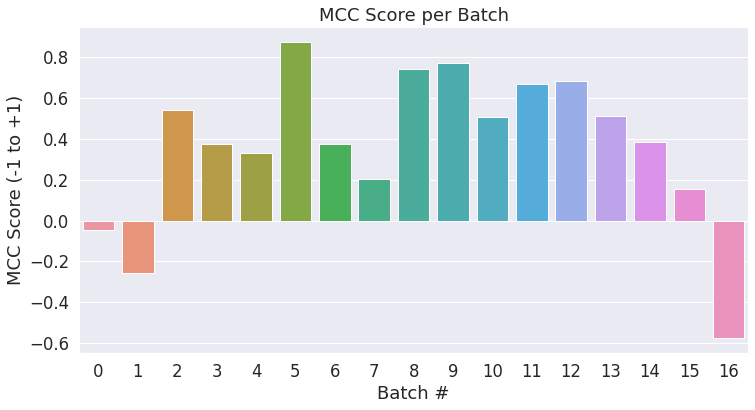

In [ ]:
# 建立柱狀圖來顯示每個 batch 的 MCC 分數
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# 合併所有 batch 的預測結果
flat_predictions = np.concatenate(predictions, axis=0)

# 取每個樣本的最大值作為預測值
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# 合併所有的 labels
flat_true_labels = np.concatenate(true_labels, axis=0)

# 計算 MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.419
